In [1]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import pandas as pd
import pylab
import scipy as sp
import scipy.stats

from datetime import datetime
from matplotlib.ticker import MultipleLocator
from numpy import array, polyfit, poly1d
from pandas import DataFrame, to_datetime
from pandas.plotting import register_matplotlib_converters
from scipy.stats import norm,rayleigh
from tkinter import *
from tkinter import filedialog

register_matplotlib_converters()

%matplotlib inline

In [2]:
def get_PRIM_file():

# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data", title = "Select PRIM master file",\
                        filetypes = (("Prim files","*.Prim"),("Prim files","*.prim"),("all files","*.*")))
    root.destroy()

    return(root.filename)

In [3]:
def get_SECO_file():

# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data", title = "Select SECO master file",\
                        filetypes = (("Seco files","*.Seco"),("Seco files","*.seco"),("all files","*.*")))
    root.destroy()

    return(root.filename)

In [4]:
def get_DSECO_file():

# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data\Master_files", title = "Select DSECO master file",\
                        filetypes = (("Dseco files","*.CORRECTED"),("Dseco files","*.corrected"),("all files","*.*")))
    root.destroy()

    return(root.filename)

In [5]:
def Get_Prim_records():
    PRIM_rectype = np.dtype([
        ('Procid','B', (12,)),
        ('Loc','i'),
        ('date_val','i2',(12)),
        ('Hsig','f'), ('Thsig','f'), ('Hrms', 'f'), ('Hmax', 'f'),('Tc', 'f'),('Tz', 'f'), ('H10', 'f'), 
        ('Th10', 'f'), ('Thmax', 'f'), ('Tzmax', 'f'), ('Hm0', 'f'),('T02', 'f'),('Tp', 'f'), ('EPS', 'f'), 
        ('Npts', 'i'),
        ('Param2','f', (4,))])

# Get name of input PRIM file
    Input_Prim_File = get_PRIM_file()

    # Open file
    f = open(Input_Prim_File)
    print('Getting PRIM data')

    # Read data from the Binary file into a DF based on the structure in the DT
    data = np.fromfile(f, PRIM_rectype)
    PRIM_recs = DataFrame.from_records(np.array(data).tolist())

    PRIM_recs.columns = ['Procid','Loc','date_val','Hsig','Thsig','Hrms','Hmax','Tc','Tz',
                    'H10','Th10','Thmax','Tzmax','Hm0','T02','Tp','EPS','Npts','Param2']

    # Remove errant zero's from data
    PRIM_recs = PRIM_recs.loc[PRIM_recs.date_val.apply(lambda x: x[0])!=0]

    # Convert date/time column data into Dates and times
    Record_time = pd.DataFrame(PRIM_recs.date_val.values.tolist(), \
            columns=['year','j1','month','j2','day','j3','hour','j4','minute','j5','second','j6'])

    Record_time['year'] = Record_time['year'].mask(Record_time['year'] < 1900, Record_time['year'] + 1900)

    # Insert Date column at start of DF
    PRIM_recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

    # Remove unwanted columns from the DF
    PRIM_recs = PRIM_recs.drop(columns=[
        'Procid',
        'Loc',
        'date_val',
        'Param2'], axis=1)

    return(PRIM_recs)

In [6]:
def Get_Seco_records():
    # Create a DT based on the structure type of the SECO Master File

    SECO_rectype = np.dtype([('Loc','i'),
    #                    ('Year','i'),('Month','i'),('Day', 'i'),('Hour', 'i'),('Min', 'i'), ('Sec','i'),
                        ('date_val','i2',(12)),
                        ('Spc', 'f', (60,))
                       ])

    # Get name of input SECO file
    Input_Seco_File = get_SECO_file()

    # Open file
    f = open(Input_Seco_File)
    print('Getting SECO data')
    
    # Read data from the Binary file into a DF based on the structure in the DT
    data = np.fromfile(f, SECO_rectype)
    SECO_recs = DataFrame.from_records(np.array(data).tolist())

    SECO_recs.columns = ['Loc','date_val','Spc']

    # Remove errant zero's from data
    SECO_recs = SECO_recs.loc[SECO_recs.date_val.apply(lambda x: x[0])!=0]


    # Convert date/time column data into Dates and times
    Record_time = pd.DataFrame(SECO_recs.date_val.values.tolist(), \
            columns=['year','j1','month','j2','day','j3','hour','j4','minute','j5','second','j6'])

    Record_time['year'] = Record_time['year'].mask(Record_time['year'] < 1900, Record_time['year'] + 1900)

    # Insert Date column at start of DF
    SECO_recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

    SECO_recs = SECO_recs.drop(['Loc', 'date_val'], axis=1)

    return(SECO_recs)

In [7]:
def Get_Dseco_records():
    # Create a DT based on the structure type of the DSECO Master File
    rectype = np.dtype([
                        ('Procid','B',(12,)),
                        ('Loc','i'),
                        ('date_val','i2',(12)),
                        ('Elapse','i2',(2)),
                        ('Hm0','f'),('T02','f'),('Pdens','f'),('Temp','f'),
                        ('Vacc','f'),('Xacc','f'),('Yacc','f'),
                        ('Orient','f'),('Inclin','f'),
                        ('Tp_buoy','f'),('Avg_dir','f'),('Peak_dir','f'),
                        ('Corr_to_True','f'),
                        ('jdirn', 'i2', (64)),('jrpower', 'i2', (64)),('jspread', 'i2', (64)),                     
                       ])

    # Get name of input DSECO file
    Input_DSECO_File = get_DSECO_file()

    # Open file
    f = open(Input_DSECO_File)
    print('Getting DSECO data')

    # Read data from the Binary file into a DF based on the structure in the DT
    data = np.fromfile(f, rectype)
    DSECO_recs = DataFrame.from_records(np.array(data).tolist())

    DSECO_recs.columns = ['Procid','Loc','date_val','Elapse',
                            'Hm0','T02','Pdens','Temp',
                            'Vacc','Xacc','Yacc',
                            'Orient','Inclin',
                            'Tp_buoy','Avg_dir','Peak_dir',
                            'Corr_to_True','jdirn','jrpower','jspread']

    # Locate and remove errant zero's from data
    zero_data = DSECO_recs.loc[DSECO_recs.date_val.apply(lambda x: x[0])==0].index

    if len(zero_data) > 0:
        DSECO_recs_zero = DSECO_recs    # make a copy to locate where the zeros occur
        date_string =  [[DSECO_recs.loc[zero_data[0]-1].date_val.tolist()][0][i] for i in range(0,10,2)]
        ' '.join(str(p) for p in [date_string])
        first_val = str(date_string[0])+'/'+str(date_string[1])+'/'+str(date_string[2])+' '+str(date_string[3]) \
            +':'+str(date_string[4])
        date_string =  [[DSECO_recs.loc[zero_data[-1]+1].date_val.tolist()][0][i] for i in range(0,10,2)]
        ' '.join(str(p) for p in [date_string])
        last_val = str(date_string[0])+'/'+str(date_string[1])+'/'+str(date_string[2])+' '+str(date_string[3]) \
            +':'+str(date_string[4])
        print('Alert: ',len(zero_data),' Zero\'s found (and removed) between ',first_val,' and ',last_val)

        DSECO_recs = DSECO_recs.loc[DSECO_recs.date_val.apply(lambda x: x[0])!=0]    # remove the zeros from the df

    # Convert date/time column data into Dates and times
    Record_time = pd.DataFrame(DSECO_recs.date_val.values.tolist(), \
            columns=['year','j1','month','j2','day','j3','hour','j4','minute','j5','second','j6'])

    # Correct dates for two-digit year 
    Record_time['year'] = Record_time['year'].mask(Record_time['year'] < 1900, Record_time['year'] + 1900)

    # Insert Date column at start of DF
    DSECO_recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

    # Insert Date column at start of DF
    DSECO_recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

    DSECO_recs = DSECO_recs.drop(['Loc', 'date_val'], axis=1)

    return(DSECO_recs)

In [8]:
def calc_spectral_moments(f,Spectra):
# calculate m0, m1, m2, m4 from spectra    

    f = np.asarray(f)
    
    f1 = f[0]; f2 = f[-1]
    
    # calculation of the spectral moments    
    ind_f = np.where((f >= f1) & (f <= f2))[0]   
    
    m0 = np.trapz(Spectra[ind_f]*f[ind_f]**0,f[ind_f])
    m1 = np.trapz(Spectra[ind_f]*f[ind_f]**1,f[ind_f])           
    m2 = np.trapz(Spectra[ind_f]*f[ind_f]**2,f[ind_f])           
    m4 = np.trapz(Spectra[ind_f]*f[ind_f]**4,f[ind_f])           
    
    return m0,m1,m2,m4

def get_parameters_Banded(f,Spectra):
    m0,m1,m2,m4 = calc_spectral_moments(f,Spectra)    
    
# calc wave parameters Hm0, Hrms, T01, T02, Tc
    Hm0 = 4*np.sqrt(m0);     # Tucker & Pitt p.32 (2.2-6b)
    Hrms = np.sqrt(8*Hm0)    # Goda 2nd. Edition p.262 (9.15)
    T01 = m0/m1;             # Tucker & Pitt p.41 Table 2.2 
    T02 = np.sqrt(m0/m2);    # Tucker & Pitt p.40 (2.3-2)
    Tc = np.sqrt(m2/m4)      # Tucker & Pitt p.41 Table 2.2 - also see Notes
    
    # identify spectral peak and frequency at peak    
    max_frequency = [k for k, j in enumerate(Spectra) if j == np.max(Spectra)]
    Fp = f[max_frequency[0]]; Tp = 1/Fp 

    return(Hm0,Hrms,T01,T02,Tc,Tp)   # get_parameters_Banded()

In [9]:
def Get_SECO_parameters(SECO_recs):
    freq = []
    for i in range(60): freq.append(0.025+i*0.01)

    Parameter_list = []

    print('Calculating "Hm0" "Hrms" "T01" "T02" "Tc" "Tp" from Spectral ordinates!')
    print('Note - this will take a few minutes.')
    for i in range(len(SECO_recs)):
        Parameter_list.append(list(get_parameters_Banded(freq,SECO_recs.iloc[i].Spc)))

    SECO_parameter_df = pd.DataFrame.from_records(Parameter_list)    
    SECO_parameter_df.rename(columns={0: 'Hm0', 1: 'Hrms', 2: 'T01', 3: 'T02',4: 'Tc', 5: 'Tp'}, inplace=True)
    SECO_parameter_df.index = SECO_recs.index
    
    return(SECO_parameter_df)

Getting PRIM data
Getting SECO data
Getting DSECO data
Calculating "Hm0" "Hrms" "T01" "T02" "Tc" "Tp" from Spectral ordinates!
Note - this will take a few minutes.


No handles with labels found to put in legend.


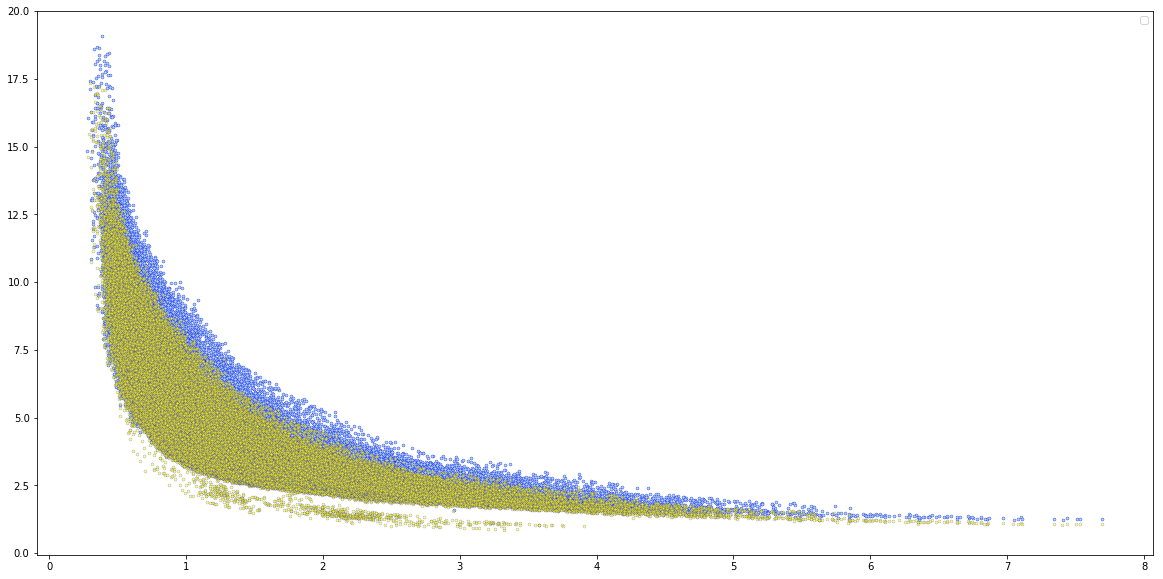

In [10]:
#######################################
#               MAIN
#######################################

PRIM_recs = Get_Prim_records()
SECO_recs = Get_Seco_records()
DSECO_recs = Get_Dseco_records()

Parameter_df = Get_SECO_parameters(SECO_recs)

plt.figure(figsize=(20, 10))
plt.plot(PRIM_recs.Hm0,PRIM_recs.T02/PRIM_recs.Hm0,marker='o',lw=0,mec='b',mew=0.3,ms = 3, c = 'lightblue')
plt.plot(Parameter_df.Hm0,Parameter_df.T02/Parameter_df.Hm0,marker='o',lw=0,mec='b',mew=0.3,ms = 3, c = 'yellow',alpha=0.5)
plt.legend()
plt.show()

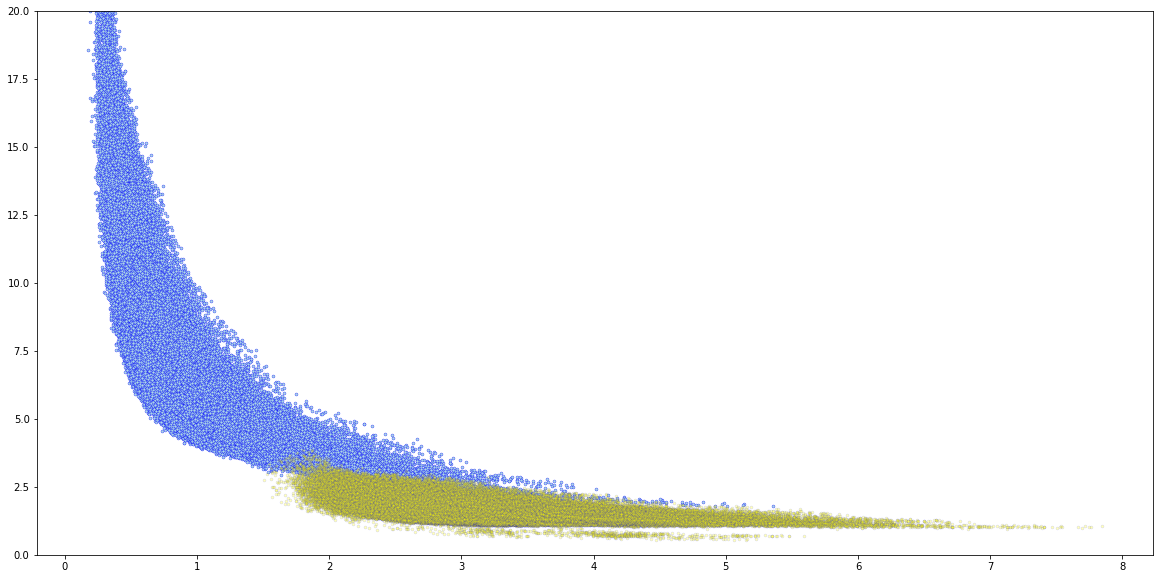

In [11]:
plt.figure(figsize=(20, 10))
plt.plot(PRIM_recs.Hrms,PRIM_recs.T02/PRIM_recs.Hrms,marker='o',lw=0,mec='b',mew=0.3,ms = 3, c = 'lightblue')
plt.plot(Parameter_df.Hrms,Parameter_df.T02/Parameter_df.Hrms,marker='o',lw=0,mec='b',mew=0.3,ms = 3, c = 'yellow',alpha=0.25)
plt.ylim(0,20)
plt.show()

In [12]:
dates = PRIM_recs.index.intersection(Parameter_df.index)

In [13]:
df_PRIM_SECO = pd.merge(PRIM_recs,Parameter_df, left_index=True, right_index=True)

In [ ]:
df = pd.merge(PRIM_recs,Parameter_df, left_index=True, right_index=True)plt.figure(figsize=(20, 10))
plt.plot(PRIM_recs.index,PRIM_recs.Hm0,marker='o',lw=0,mec='b',mew=0.3,ms = 1, c = 'lightblue')
#plt.plot(Parameter_df.index,Parameter_df.Hm0,marker='o',lw=0,mec='b',mew=0.3,ms = 1, c = 'yellow',alpha=0.5)
plt.plot(DSECO_recs.index,DSECO_recs.Hm0,marker='o',lw=0,mec='b',mew=0.3,ms = 3, c = 'pink',alpha=0.3)
#lt.xlim(0,10)
plt.ylim(0,10)
plt.show()

In [15]:
df_PRIM_SECO = pd.merge(PRIM_recs,Parameter_df, left_index=True, right_index=True)
df_PRIM_DSECO = pd.merge(PRIM_recs,DSECO_recs, left_index=True, right_index=True)
df_SECO_DSECO = pd.merge(SECO_recs,DSECO_recs, left_index=True, right_index=True)

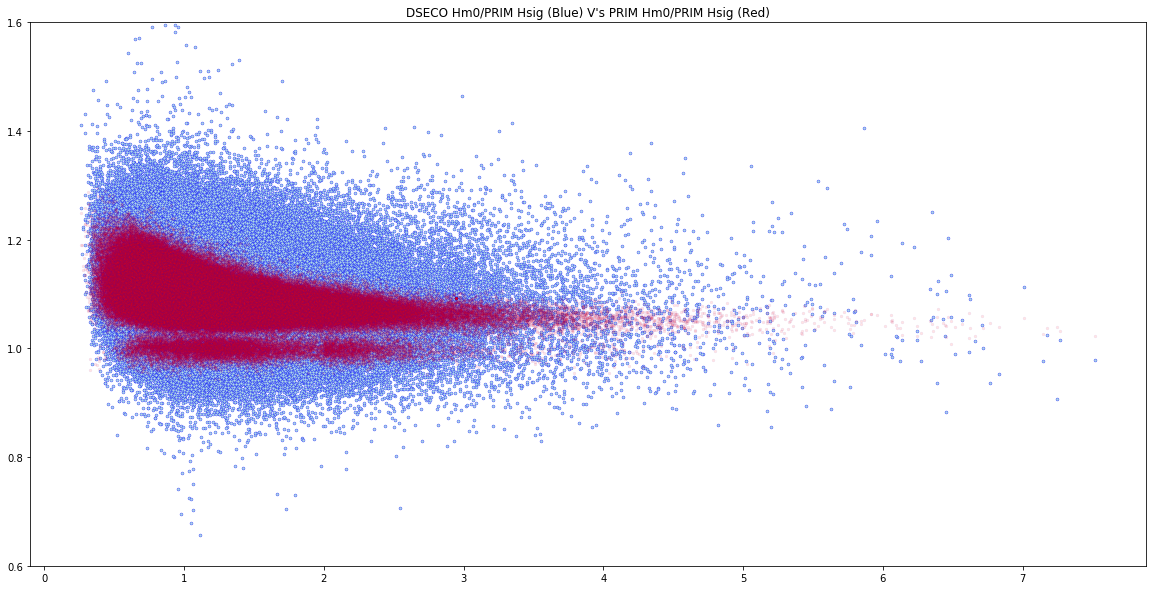

In [16]:
plt.figure(figsize=(20, 10))
plt.plot(df_PRIM_DSECO.Hsig,df_PRIM_DSECO.Hm0_y/df_PRIM_DSECO.Hsig,marker='o',lw=0,mec='b',mew=0.3,ms = 3, c = 'lightblue')
plt.plot(df_PRIM_DSECO.Hsig,df_PRIM_DSECO.Hm0_x/df_PRIM_DSECO.Hsig,marker='o',lw=0,mec='b',mew=0.3,ms = 3, c = 'yellow',alpha=0.1)
#plt.xlim(0,10)
plt.ylim(0.6,1.6)
plt.title("DSECO Hm0/PRIM Hsig (Blue) V's PRIM Hm0/PRIM Hsig (Yellow)")

plt.show()

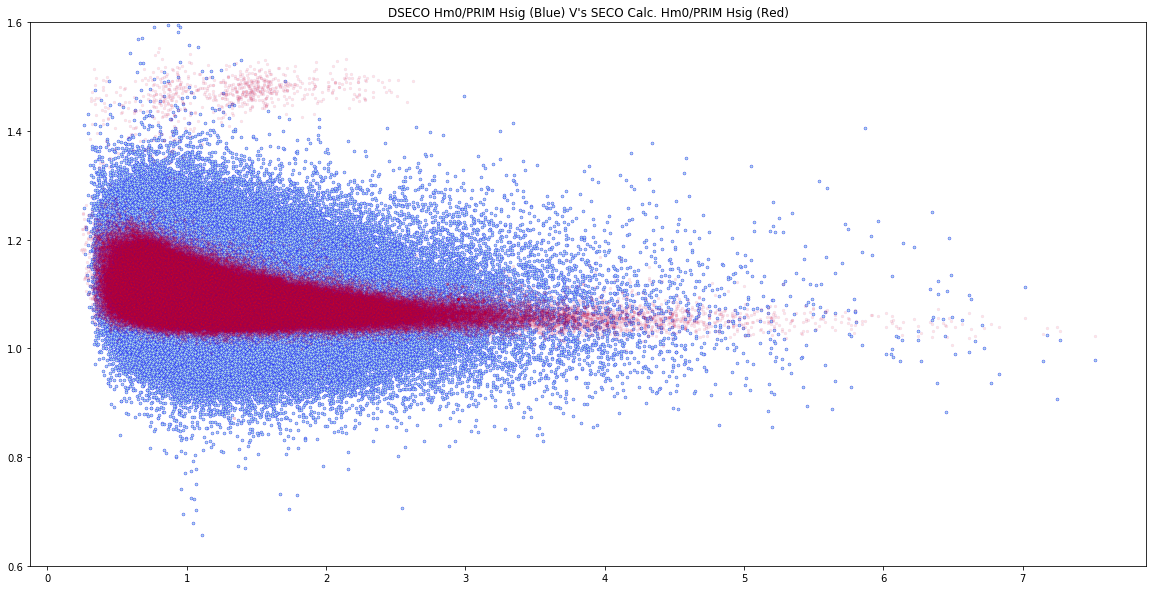

In [17]:
plt.figure(figsize=(20, 10))
plt.plot(df_PRIM_DSECO.Hsig,df_PRIM_DSECO.Hm0_y/df_PRIM_DSECO.Hsig,marker='o',lw=0,mec='b',mew=0.3,ms = 3, c = 'lightblue')
plt.plot(df_PRIM_SECO.Hsig,df_PRIM_SECO.Hm0_y/df_PRIM_SECO.Hsig,marker='o',lw=0,mec='b',mew=0.3,ms = 3, c = 'yellow',alpha=0.1)
#plt.xlim(0,10)
plt.ylim(0.6,1.6)
plt.title("DSECO Hm0/PRIM Hsig (Blue) V's SECO Calc. Hm0/PRIM Hsig (Yellow)")

plt.show()

In [ ]:
# Calc freuqencies for DSECO spectra Vide DWRF May 2018 p.48 Table 5.7.3
freq = []
for i in range(64):
            if i<16:
                freq.append(0.025+i*0.005) 
            else:
                freq.append(0.11+(i-16)*0.01)

# Calc freuqencies for SECO spectra Vide L&T RTWS Analysis Package - August 1998 (Man6\#1294-V7.00) p.41
freq_SECO = []
for ii in range(60):
            freq_SECO.append(0.005+ii*0.01) 
print('Better grab yourself a cup of coffee - this is going to take a while!')
                
print('                  |--------- From DSECO Spectra ---------|  |--------- From SECO Spectra ----------|')
print('        Date      Hm0_1 Hrms_1  T01_1  T02_1   Tc_1   Tp_1  Hm0_2 Hrms_2  T01_2  T02_2   Tc_2   Tp_2')

# Creating an empty Dataframe with column names only
df_parameters = pd.DataFrame(columns=['Date','Hm0_1','Hrms_1','T01_1','T02_1','Tc_1','Tp_1','Hm0_2','Hrms_2','T01_2','T02_2','Tc_2','Tp_2'])

for j in range(len(df_SECO_DSECO)):
# Calc selected parameters from DSECO spectral ordinates (applying formula to derive Relative power spectral density - from DWRF p.48 Table 5.7.3)
    Hm0_1,Hrms_1,T01_1,T02_1,Tc_1,Tp_1 = get_parameters_Banded(freq,np.exp(-df_SECO_DSECO.iloc[j].jrpower/200.)*df_SECO_DSECO.iloc[j].Pdens)

# Calc selected parameters from SECO spectral ordinates
    Hm0_2,Hrms_2,T01_2,T02_2,Tc_2,Tp_2 = get_parameters_Banded(freq_SECO,df_SECO_DSECO.iloc[j].Spc)

##    print('{:%Y-%m-%d %H:%M}{:7.2f}{:7.2f}{:7.2f}{:7.2f}{:7.2f}{:7.2f}{:7.2f}{:7.2f}{:7.2f}{:7.2f}{:7.2f}{:7.2f}'.\
##          format(df_SECO_DSECO.index[j],Hm0_1,Hrms_1,T01_1,T02_1,Tc_1,Tp_1,Hm0_2,Hrms_2,T01_2,T02_2,Tc_2,Tp_2))
    df_parameters = df_parameters.append({'Date':df_SECO_DSECO.index[j],'Hm0_1':Hm0_1,'Hrms_1':Hrms_1,'T01_1':T01_1,'T02_1':T02_1,'Tc_1':Tc_1,'Tp_1':Tp_1,
                                            'Hm0_2':Hm0_2,'Hrms_2':Hrms_2,'T01_2':T01_2,'T02_2':T02_2,'Tc_2':Tc_2,'Tp_2':Tp_2}, ignore_index=True)
    
df_parameters.set_index('Date', inplace = True)

##plt.figure(figsize=(20, 10))
##plt.plot(freq,np.exp(-df_SECO_DSECO.iloc[j].jrpower/200.)*df_SECO_DSECO.iloc[j].Pdens,marker='o',lw=2,mec='b',mew=0.5,ms = 5, c = 'lightblue')
##plt.plot(freq_SECO,df_SECO_DSECO.iloc[j].Spc,marker='o',lw=2,mec='b',mew=0.5,ms = 5, c = 'red')


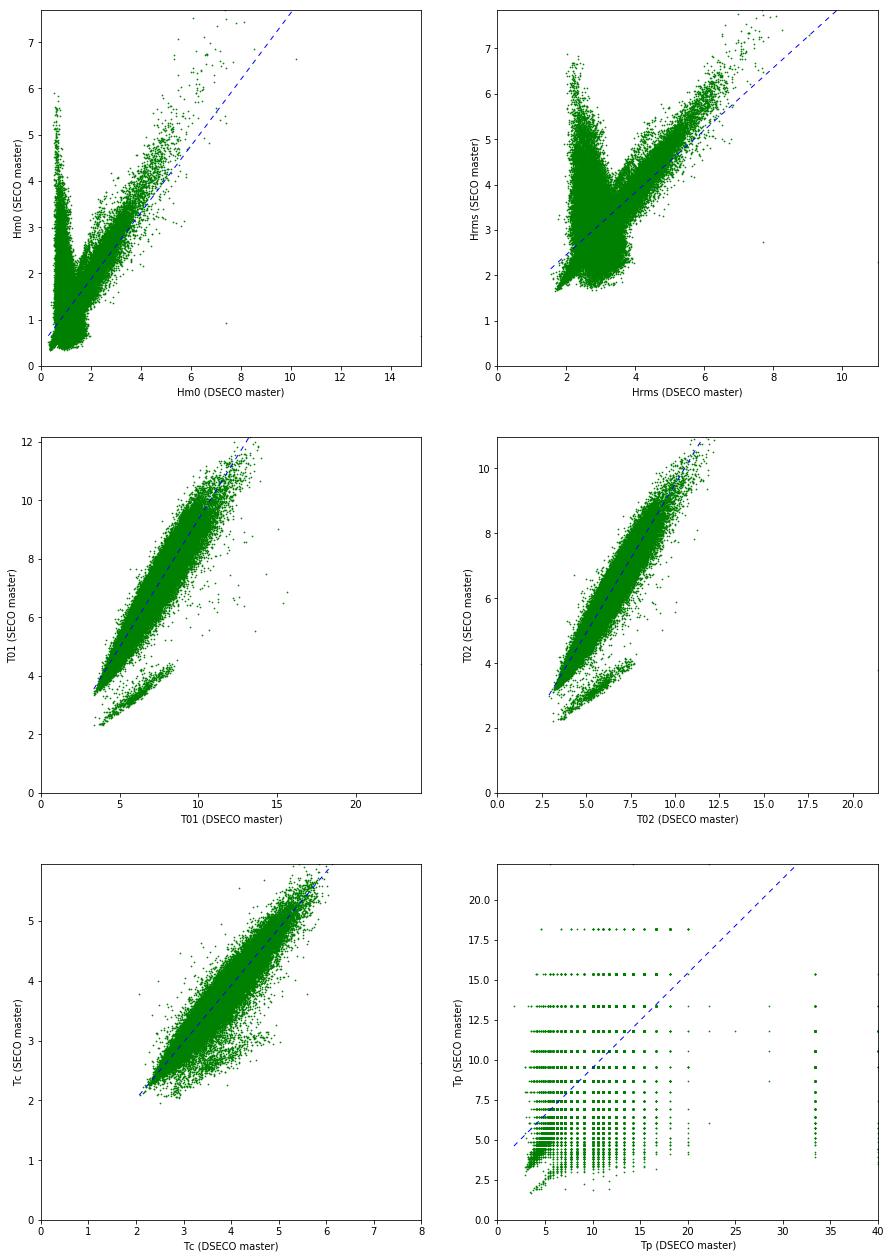

In [24]:
from matplotlib.dates import DateFormatter
from numpy.polynomial import Polynomial

# Display comparisons of main parameters between DSECO and SECO master files
plt.rcParams['axes.facecolor'] = 'white'

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,20), facecolor=(1, 1, 1))
#fig.suptitle(Input_Prim_File+'\n'+(recs_RTWS_prim.loc[idx].index[0]).strftime('%m/%d/%Y')+' to '+(recs_RTWS_prim.loc[idx].index[-1]).strftime('%m/%d/%Y'))
#fig.tight_layout()
fig.subplots_adjust(top=0.965)

# Do scatter plot of DSECO Hm0 v's SECO Hm0
ax1.scatter(df_parameters.Hm0_1,df_parameters.Hm0_2,s=0.5,c='g')
ax1.set_xlim(0,max(df_parameters.Hm0_1))
ax1.set_ylim(0,max(df_parameters.Hm0_2))
ax1.set_xlabel("Hm0 (DSECO master)")
ax1.set_ylabel("Hm0 (SECO master)")

p = Polynomial.fit(df_parameters.Hm0_1,df_parameters.Hm0_2,1)
ax1.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of DSECO Hrms v's SECO Hrms
ax2.scatter(df_parameters.Hrms_1,df_parameters.Hrms_2,s=0.5,c='g')
ax2.set_xlim(0,max(df_parameters.Hrms_1))
ax2.set_ylim(0,max(df_parameters.Hrms_2))
ax2.set_xlabel("Hrms (DSECO master)")
ax2.set_ylabel("Hrms (SECO master)")

p = Polynomial.fit(df_parameters.Hrms_1,df_parameters.Hrms_2,1)
ax2.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of DSECO T01 v's SECO T01
ax3.scatter(df_parameters.T01_1,df_parameters.T01_2,s=0.5,c='g')
ax3.set_xlim(0,max(df_parameters.T01_1))
ax3.set_ylim(0,max(df_parameters.T01_2))
ax3.set_xlabel("T01 (DSECO master)")
ax3.set_ylabel("T01 (SECO master)")

p = Polynomial.fit(df_parameters.T01_1,df_parameters.T01_2,1)
ax3.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of DSECO T02 v's SECO T02
ax4.scatter(df_parameters.T02_1,df_parameters.T02_2,s=0.5,c='g')
ax4.set_xlim(0,max(df_parameters.T02_1))
ax4.set_ylim(0,max(df_parameters.T02_2))
ax4.set_xlabel("T02 (DSECO master)")
ax4.set_ylabel("T02 (SECO master)")

p = Polynomial.fit(df_parameters.T02_1,df_parameters.T02_2,1)
ax4.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of DSECO Tc v's SECO Tc
ax5.scatter(df_parameters.Tc_1,df_parameters.Tc_2,s=0.5,c='g')
ax5.set_xlim(0,max(df_parameters.Tc_1))
ax5.set_ylim(0,max(df_parameters.Tc_2))
ax5.set_xlabel("Tc (DSECO master)")
ax5.set_ylabel("Tc (SECO master)")

p = Polynomial.fit(df_parameters.Tc_1,df_parameters.Tc_2,1)
ax5.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of DSECO Tp v's SECO Tp
ax6.scatter(df_parameters.Tp_1,df_parameters.Tp_2,s=0.5,c='g')
ax6.set_xlim(0,max(df_parameters.Tp_1))
ax6.set_ylim(0,max(df_parameters.Tp_2))
ax6.set_xlabel("Tp (DSECO master)")
ax6.set_ylabel("Tp (SECO master)")

p = Polynomial.fit(df_parameters.Tp_1,df_parameters.Tp_2,1)
ax6.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])
                   
plt.show()                   


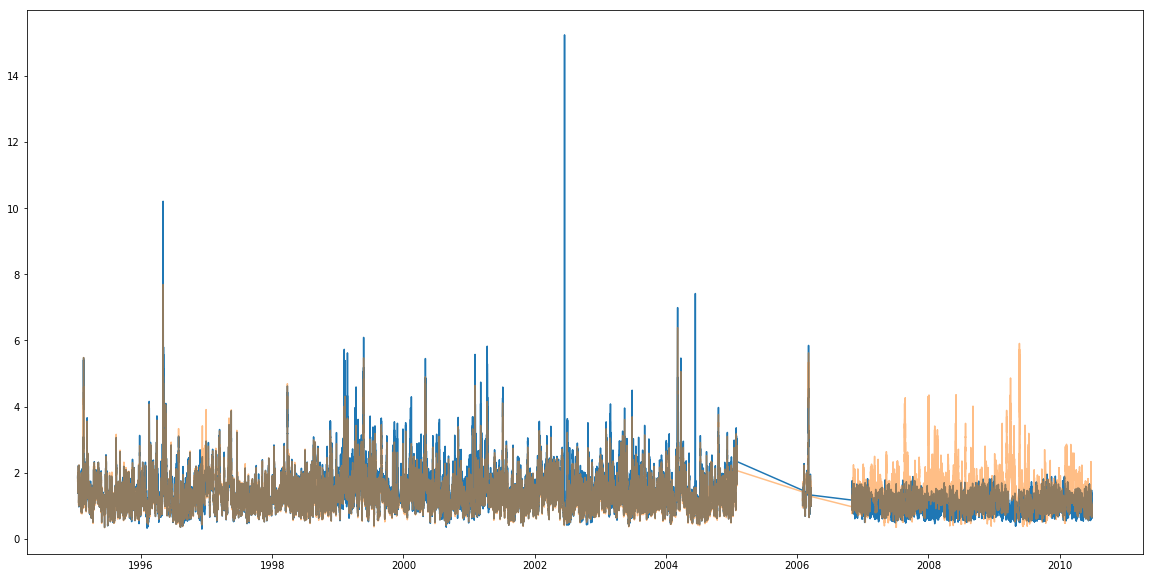

In [29]:
plt.figure(figsize=(20, 10))
plt.plot(df_parameters.Date,df_parameters.Hm0_1)
plt.plot(df_parameters.Date,df_parameters.Hm0_2,alpha=0.5)

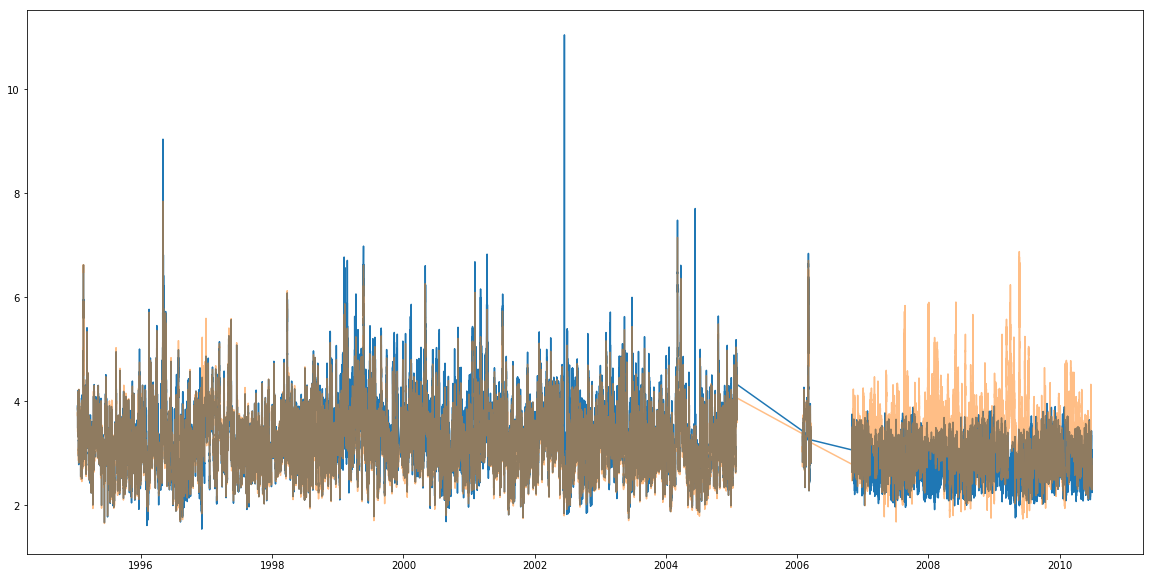

In [30]:
plt.figure(figsize=(20, 10))
plt.plot(df_parameters.Date,df_parameters.Hrms_1)
plt.plot(df_parameters.Date,df_parameters.Hrms_2,alpha=0.5)

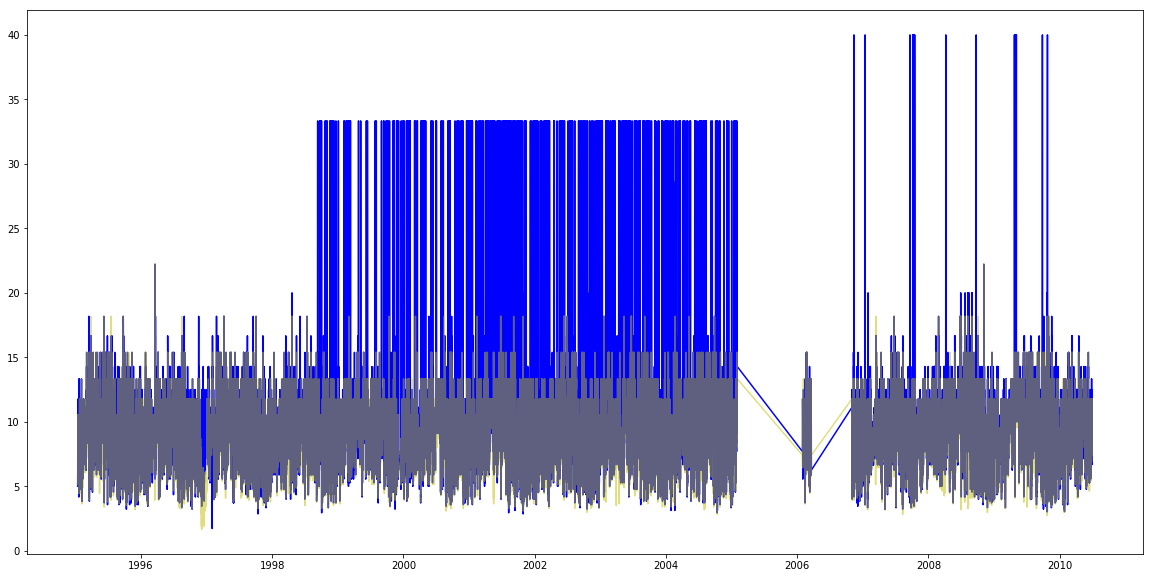

In [38]:
plt.figure(figsize=(20, 10))
plt.plot(df_parameters.Date,df_parameters.Tp_1,c='b')
plt.plot(df_parameters.Date,df_parameters.Tp_2,c='y',alpha=0.5)